## TS plots and linear relationship

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import cmocean
import matplotlib.dates as mdates
import cmocean
import gsw
from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib import gridspec

In [4]:
# open Sverdrup 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
sverdrup_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Sverdrup_1D_L3.nc")
sverdrup_ds.close()

In [5]:
# open Rink 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
rink_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Rink_1D_L3.nc")
rink_ds.close()

In [6]:
# open Fisher Islands 2020 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
fisher_ds = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_Fisher_1D_L3.nc')
fisher_ds.close()

In [7]:
# open Kong Oscar 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
kongoscar19 = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_KongOscar2019_1D_L3.nc")
kongoscar19.close()

In [8]:
# open Kong Oscar 2020 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
kongoscar20 = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_KongOscar2020_1D_L3.nc')
kongoscar20.close()

***

Function that calculates density grid using temperature and salinity data (for density contours of TS plot)

In [26]:
def sigma_theta_grid(theta_ds, salt_ds):
    min_theta = theta_ds.min()
    max_theta = theta_ds.max()
    min_salt  = salt_ds.min()
    max_salt  = salt_ds.max()
    
    theta_vals = np.linspace(min_theta-0.5, max_theta+0.5, 156)
    salt_vals  = np.linspace(min_salt-0.05, max_salt+0.05, 156)
    
    Sgrid, Tgrid = np.meshgrid(salt_vals,theta_vals)
    sigma_theta_2d = gsw.sigma0(Sgrid, Tgrid)
    
    return salt_vals, theta_vals, sigma_theta_2d

In [27]:
def plot_TS(mooring_ds, savefig=True):
    
    # extract pot temp and salinity data
    salt_ds = mooring_ds.salinity
    theta_ds = mooring_ds.potential_temperature.sel(Depth_CTD=salt_ds.Depth_CTD.values)
    # calculate dentisy grid
    salt_vals, theta_vals, sigma_theta_2d = sigma_theta_grid(theta_ds, salt_ds)
    # extract times
    dates = theta_ds.time.values
    # extract mooring ctd depths
    ctd_depth_shallow = mooring_ds.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds.Depth_CTD.values.max()
    
    # PLOT -------------------------------------------------------
    plt.figure(figsize=[6.5,5]);
    
    # # ctd data
    # for i in range(len(sver_ctd_ship_18.profile)):
    #     plt.plot(sver_ctd_ship_18.salinity.isel(profile=i), sver_ctd_ship_18.potential_temperature.isel(profile=i),c='k',linewidth=0.6, zorder=1)
    # for i in range(len(sver_ctd_ship_19.profile)):
    #     plt.plot(sver_ctd_ship_19.salinity.isel(profile=i), sver_ctd_ship_19.potential_temperature.isel(profile=i),c='k',linewidth=0.6, zorder=1)
    
    # plot density contour
    cs = plt.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(20.6,27.6,.2),linewidths=0.5,zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=True, fmt='%.1f')
    
    # mooring data
    colors = cmocean.cm.thermal
    # colors = cmocean.cm.phase
    plt.scatter(salt_ds.sel(Depth_CTD=ctd_depth_shallow),theta_ds.sel(Depth_CTD=ctd_depth_shallow),\
                c=mdates.date2num(dates), s=40, edgecolor='k',linewidth=0.4,\
                cmap=colors,label=str(ctd_depth_shallow)+'m')
    pts = plt.scatter(salt_ds.sel(Depth_CTD=ctd_depth_deep),theta_ds.sel(Depth_CTD=ctd_depth_deep),\
                      c=mdates.date2num(dates),s=50, marker='^',edgecolor='k',linewidth=0.4,\
                      cmap=colors,label=str(ctd_depth_deep)+'m')
    cb = plt.colorbar(pts)
    cb.ax.set_title("      Month")
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    
    # plot params
    # plt.ylim(-1,2)
    # plt.xlim(33,34.5)
    
    plt.ylabel('$\mathit{\Theta}$ (°C)')
    plt.xlabel("Salinity")
    
    # make custom legend
    # custom = [Line2D([], [], marker='o', markersize=6, color='none', markeredgecolor='k',linewidth=0.4,linestyle='None'),\
    #           Line2D([], [], marker='^', markersize=7, color='none', markeredgecolor='k',linewidth=0.4,linestyle='None')]
    plt.legend(loc='lower right')
    
    plt.title('%s mooring' % (mooring_ds.glacier_front[:-8]));
    
    if savefig == True:
        filename = 'ts_' + mooring_ds.glacier_front[:-8]
        plt.savefig("figures/TS_relationship/" + filename + ".png", bbox_inches='tight', dpi=300, facecolor='white');
        
    plt.show();

### Mooring data with shadow plot

Define values for density contour:

In [28]:
temp_array = np.concatenate((sverdrup_ds.potential_temperature.values.flatten(),\
                             rink_ds.potential_temperature.values.flatten(),\
                             fisher_ds.potential_temperature.values.flatten(),\
                             kongoscar19.potential_temperature.values.flatten(),\
                             kongoscar20.potential_temperature.values.flatten()))
max_theta = temp_array[~np.isnan(temp_array)].max()
min_theta = temp_array[~np.isnan(temp_array)].min()

In [29]:
salt_array = np.concatenate((sverdrup_ds.salinity.values.flatten(),\
                             rink_ds.salinity.values.flatten(),\
                             fisher_ds.salinity.values.flatten(),\
                             kongoscar19.salinity.values.flatten(),\
                             kongoscar20.salinity.values.flatten()))
max_salt = salt_array[~np.isnan(salt_array)].max()
min_salt = salt_array[~np.isnan(salt_array)].min()

In [30]:
theta_vals = np.linspace(min_theta-0.5, max_theta+0.5, 156)
salt_vals  = np.linspace(min_salt-0.05, max_salt+0.05, 156)

Sgrid, Tgrid = np.meshgrid(salt_vals,theta_vals)
sigma_theta_2d = gsw.sigma0(Sgrid, Tgrid)

List of mooring datasets:

In [31]:
mooring_data_list = [rink_ds, fisher_ds, kongoscar19, kongoscar20, sverdrup_ds]

Function to plot TS diagram with discrete colorbar by month

In [32]:
def plot_TS_shadow_discrete(mooring_ds, theta_vals, salt_vals, sigma_theta_2d, mooring_data_list, savefig=True):
    
    # PLOT -------------------------------------------------------
    plt.figure(figsize=[6.5,5]);
    
    # plot density contour
    cs = plt.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(20.6,27.6,.25),linewidths=0.5,zorder=1)
    manual_locations = [(32.8,2),(33,2),(33.4,2),(33.6,2),(34,2),(34.4,2)]
    cl = plt.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)
    
    # plot all mooring data in gray ------------------------------------
    for mooring_ds_i in mooring_data_list:
        ctd_depth_shallow = mooring_ds_i.Depth_CTD.values.min()
        ctd_depth_deep = mooring_ds_i.Depth_CTD.values.max()
    
        plt.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_shallow),\
                    c='silver', s=40, edgecolor='k',linewidth=0.05)
        pts = plt.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_deep),\
                          mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_deep),\
                          c='silver',s=50, marker='^',edgecolor='k',linewidth=0.05)
    
    # mooring data in color --------------------------------------------
    cmap = cmocean.cm.thermal
    # colors = cmocean.cm.phase
    # cmap = mpl.cm.viridis
    bounds = np.arange(0.5,13.5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # extract mooring ctd depths
    ctd_depth_shallow = mooring_ds.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds.Depth_CTD.values.max()
    # extract times
    dates = mooring_ds.salinity.dropna(dim='time').time
    da_months  = dates.dt.strftime("%m")
    plt.scatter(mooring_ds.salinity.sel(Depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(Depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                c=da_months, s=40, edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_shallow)+'m')
    plt.scatter(mooring_ds.salinity.sel(Depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(Depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                c=da_months,s=50, marker='^',edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_deep)+'m')
    
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=np.arange(1,13))
    cb.ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    cb.ax.set_title("      Month")
    
    plt.ylabel('$\mathit{\Theta}$ (°C)')
    plt.xlabel("Salinity")
    plt.legend(loc='lower right')
    plt.title('%s-%s %s mooring' % (str(mooring_ds.time[0].values)[0:4], str(mooring_ds.time[-1].values)[0:4], mooring_ds.glacier_front[:-8]));
    
    if savefig == True:
        filename = 'ts_' + mooring_ds.glacier_front[:-8] + '_' + str(mooring_ds.time[-1].values)[0:4]
        plt.savefig("figures/TS_relationship/" + filename + "_shadow.png", bbox_inches='tight', dpi=300, facecolor='white');
        
    plt.show();

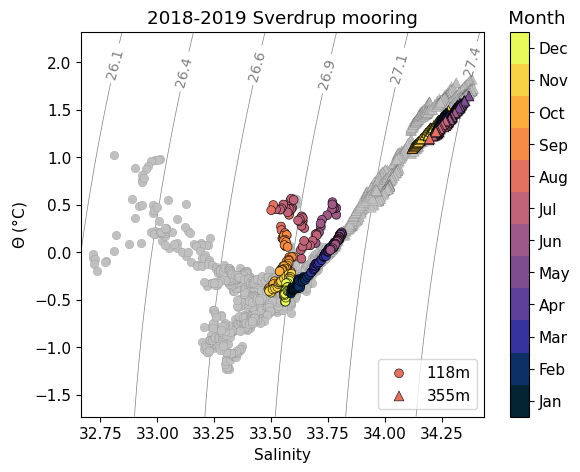

In [33]:
plot_TS_shadow_discrete(sverdrup_ds, theta_vals, salt_vals, sigma_theta_2d, mooring_data_list, savefig=False)

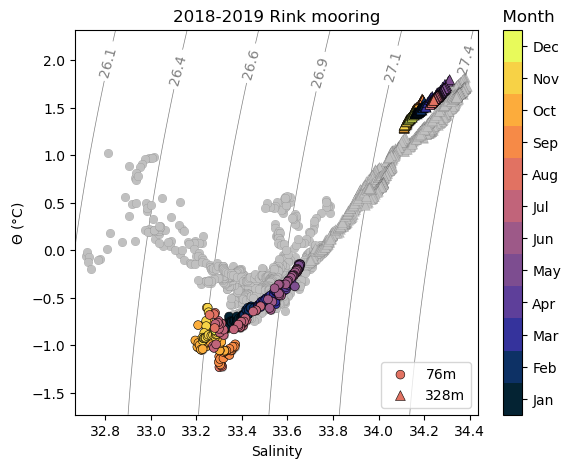

In [16]:
plot_TS_shadow_discrete(rink_ds, theta_vals, salt_vals, sigma_theta_2d, mooring_data_list, savefig=False)

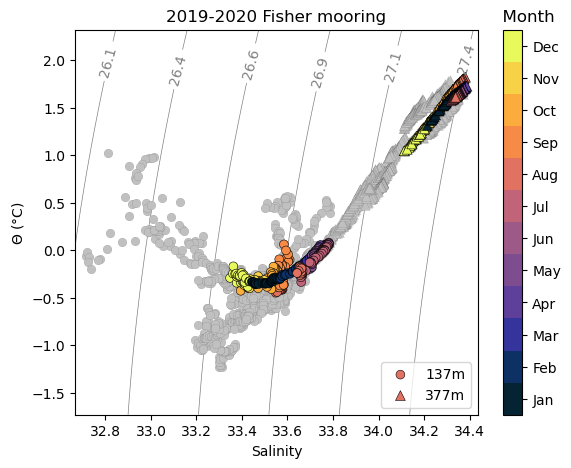

In [17]:
plot_TS_shadow_discrete(fisher_ds, theta_vals, salt_vals, sigma_theta_2d, mooring_data_list, savefig=False)

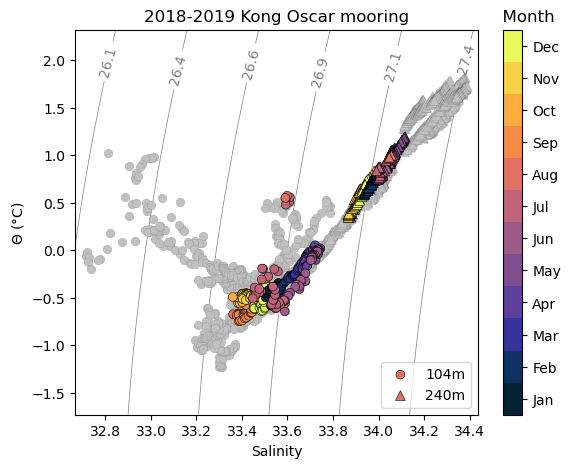

In [18]:
plot_TS_shadow_discrete(kongoscar19, theta_vals, salt_vals, sigma_theta_2d, mooring_data_list, savefig=False)

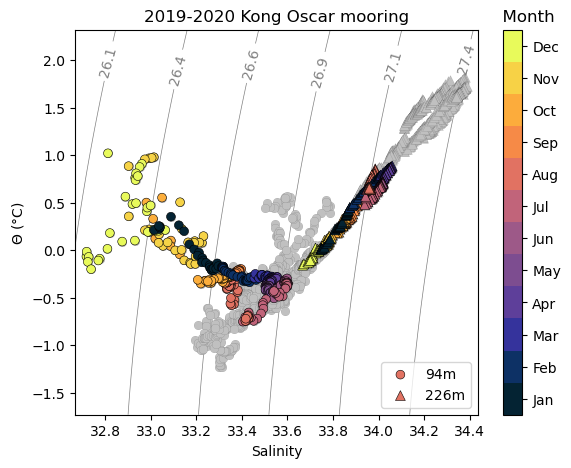

In [19]:
plot_TS_shadow_discrete(kongoscar20, theta_vals, salt_vals, sigma_theta_2d, mooring_data_list, savefig=False)

### Expected salinity using T-S linear fit (i.e., using temperature to predict salinity)

Find expression relating S and T

In [161]:
def plot_TS_shadow_discrete(mooring_ds, theta_vals, salt_vals, sigma_theta_2d, mooring_data_list, ax=None):
    
    # PLOT -------------------------------------------------------
    plt.figure(figsize=[6.5,5]);
    
    # plot density contour
    cs = plt.contour(salt_vals, theta_vals, sigma_theta_2d, ax=ax,colors='gray',levels=np.arange(20.6,27.6,.25),linewidths=0.5,zorder=1)
    manual_locations = [(32.8,2),(33,2),(33.4,2),(33.6,2),(34,2),(34.4,2)]
    cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)
    
    # plot all mooring data in gray ------------------------------------
    for mooring_ds_i in mooring_data_list:
        ctd_depth_shallow = mooring_ds_i.Depth_CTD.values.min()
        ctd_depth_deep = mooring_ds_i.Depth_CTD.values.max()
    
        ax.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_shallow),\
                    c='silver', s=40, edgecolor='k',linewidth=0.05)
        ax.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_deep),\
                   mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_deep),\
                   c='silver',s=50, marker='^',edgecolor='k',linewidth=0.05)
    
    # mooring data in color --------------------------------------------
    cmap = cmocean.cm.thermal
    # colors = cmocean.cm.phase
    # cmap = mpl.cm.viridis
    bounds = np.arange(0.5,13.5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # extract mooring ctd depths
    ctd_depth_shallow = mooring_ds.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds.Depth_CTD.values.max()
    # extract times
    dates = mooring_ds.salinity.dropna(dim='time').time
    da_months  = dates.dt.strftime("%m")
    ax.scatter(mooring_ds.salinity.sel(Depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(Depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                c=da_months, s=40, edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_shallow)+'m')
    ax.scatter(mooring_ds.salinity.sel(Depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(Depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                c=da_months,s=50, marker='^',edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_deep)+'m')
    
    # cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=np.arange(1,13))
    # cb.ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    # cb.ax.set_title("      Month")
    
    ax.set_ylabel('$\mathit{\Theta}$ (°C)')
    ax.set_xlabel("Salinity")
    ax.legend(loc='lower right')
    ax.set_title('%s-%s %s' % (str(mooring_ds.time[0].values)[0:4], str(mooring_ds.time[-1].values)[0:4], mooring_ds.glacier_front[:-8]));
        
    plt.show();

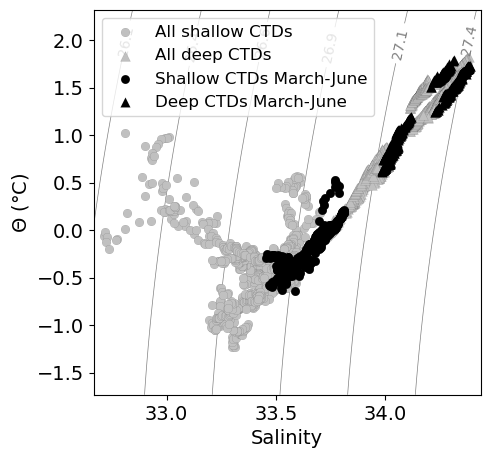

In [40]:
# PLOT -------------------------------------------------------
plt.figure(figsize=[5,5]);
plt.rcParams['font.size'] = '14'

# plot density contour
cs = plt.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(20.6,27.6,.25),linewidths=0.5,zorder=1)
manual_locations = [(32.8,2),(33,2),(33.4,2),(33.6,2),(34,2),(34.4,2)]
cl = plt.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)

# plot all mooring data in gray ------------------------------------
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.Depth_CTD.values.max()

    plt.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_shallow),\
                mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_shallow),\
                c='silver', s=40, edgecolor='k',linewidth=0.05)
    plt.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_deep),\
                mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_deep),\
                c='silver',s=50, marker='^',edgecolor='k',linewidth=0.05)

# plot mooring data in months Feb-Jun ------------------------------------
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.Depth_CTD.values.max()
    
    if '2018' in str(mooring_ds_i.time.values[0]):
        plt.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow),\
                    c='k', s=40, edgecolor='k',linewidth=0.05)
        plt.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep),\
                    c='k',s=50, marker='^',edgecolor='k',linewidth=0.05)
    if '2019' in str(mooring_ds_i.time.values[0]):
        plt.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_shallow),\
                    c='k', s=40, edgecolor='k',linewidth=0.05)
        plt.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_deep),\
                    c='k',s=50, marker='^',edgecolor='k',linewidth=0.05)       

# for legend  
plt.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_shallow).isel(time=0),\
            c='silver', s=40, edgecolor='k',linewidth=0.05, label='All shallow CTDs')
plt.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_deep).isel(time=0),\
            c='silver',s=50, marker='^',edgecolor='k',linewidth=0.05, label='All deep CTDs')
plt.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow).isel(time=0),\
            c='k', s=40, edgecolor='k',linewidth=0.05, label='Shallow CTDs March-June')
plt.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep).isel(time=0),\
            c='k',s=50, marker='^',edgecolor='k',linewidth=0.05, label='Deep CTDs March-June')

plt.legend(loc='upper left',fontsize=12)
plt.ylabel('$\mathit{\Theta}$ (°C)')
plt.xlabel("Salinity")
plt.show();

#### Make multi-panel plots

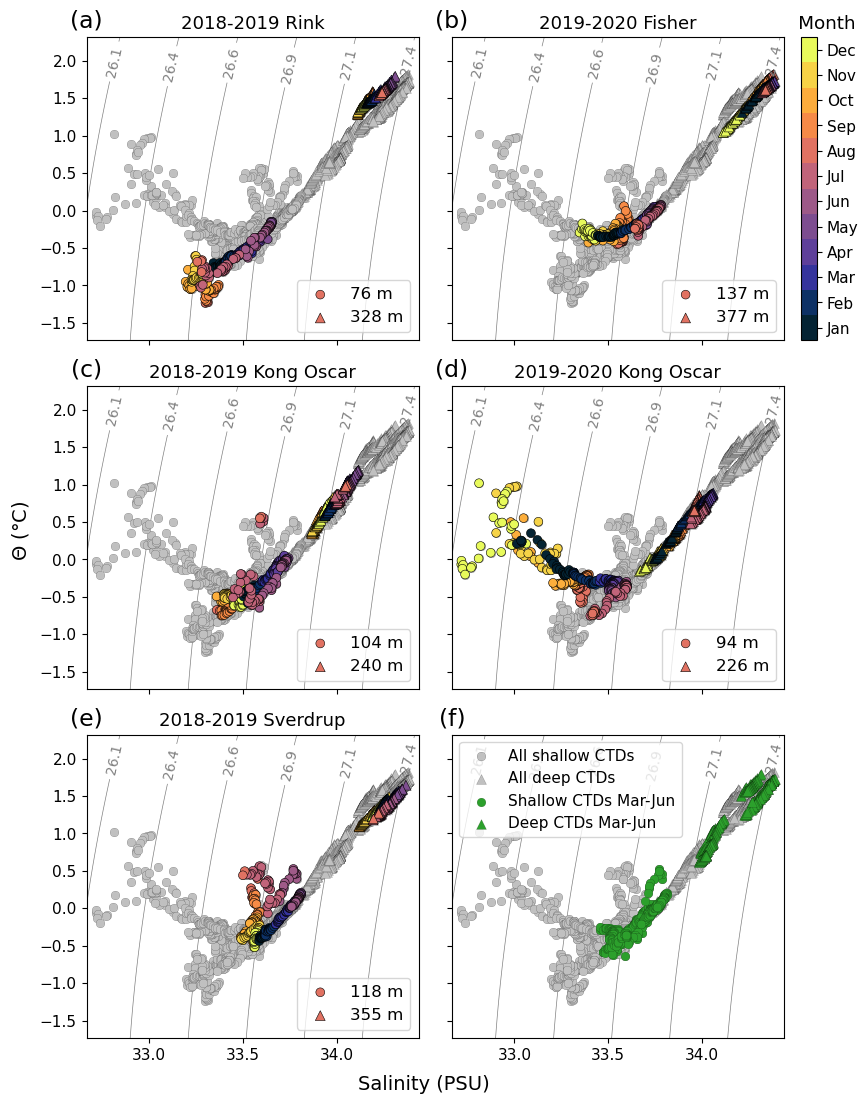

In [123]:
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=[9,13])
(ax1,ax2,ax3,ax4,ax5,ax6) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)
## Plot March-June points ================================================
# plot density contour
cs = ax6.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(20.6,27.6,.25),linewidths=0.5,zorder=1)
manual_locations = [(32.8,2),(33,2),(33.4,2),(33.6,2),(34,2),(34.4,2)]
ax6.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)

# plot all mooring data in gray -----------------------------------------
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.Depth_CTD.values.max()

    ax6.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_shallow),\
                mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_shallow),\
                c='silver', s=40, edgecolor='k',linewidth=0.1)
    ax6.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_deep),\
                mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_deep),\
                c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1);

# plot mooring data in months Feb-Jun ------------------------------------
for mooring_ds_i in mooring_data_list:
    ctd_depth_shallow = mooring_ds_i.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds_i.Depth_CTD.values.max()
    
    if '2018' in str(mooring_ds_i.time.values[0]):
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow),\
                    c='tab:green', s=40, edgecolor='k',linewidth=0.1)
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep),\
                    c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1)
    if '2019' in str(mooring_ds_i.time.values[0]):
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_shallow),\
                    c='tab:green', s=40, edgecolor='k',linewidth=0.1)
        ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_deep),\
                    mooring_ds_i.potential_temperature.sel(time=slice('2020-03','2020-06'), Depth_CTD=ctd_depth_deep),\
                    c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1);   

# for legend  
ax6.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_shallow).isel(time=0),\
            c='silver', s=40, edgecolor='k',linewidth=0.1, label='All shallow CTDs')
ax6.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_deep).isel(time=0),\
            c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1, label='All deep CTDs')
ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_shallow).isel(time=0),\
            c='tab:green', s=40, edgecolor='k',linewidth=0.1, label='Shallow CTDs Mar-Jun')
ax6.scatter(mooring_ds_i.salinity.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep).isel(time=0),\
            mooring_ds_i.potential_temperature.sel(time=slice('2019-03','2019-06'), Depth_CTD=ctd_depth_deep).isel(time=0),\
            c='tab:green',s=50, marker='^',edgecolor='k',linewidth=0.1, label='Deep CTDs Mar-Jun')

ax6.legend(loc='upper left',fontsize=11)
ax6.text(0, 1.03, '(f)', ha='center',size=17,transform=ax6.transAxes)
# ax6.set_ylabel('$\mathit{\Theta}$ (°C)')
# ax6.set_xlabel("Salinity");

## Mooring specific TS plots ================================================
# loop through each axis and mooring dataset to plot each TS plot
for ax,mooring_ds_i,label in zip([ax1,ax2,ax3,ax4,ax5],mooring_data_list,['(a)','(b)','(c)','(d)','(e)']):
    # assign mooring dataset
    mooring_ds = mooring_ds_i
    
    # PLOT -------------------------------------------------------
    # plot density contour
    cs = ax.contour(salt_vals, theta_vals, sigma_theta_2d, colors='gray',levels=np.arange(20.6,27.6,.25),linewidths=0.5,zorder=1)
    manual_locations = [(32.8,2),(33,2),(33.4,2),(33.6,2),(34,2),(34.4,2)]
    cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f', manual=manual_locations)
    
    # plot all mooring data in gray ------------------------------------
    for mooring_ds_i in mooring_data_list:
        ctd_depth_shallow = mooring_ds_i.Depth_CTD.values.min()
        ctd_depth_deep = mooring_ds_i.Depth_CTD.values.max()
    
        ax.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_shallow),\
                    mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_shallow),\
                    c='silver', s=40, edgecolor='k',linewidth=0.1)
        ax.scatter(mooring_ds_i.salinity.sel(Depth_CTD=ctd_depth_deep),\
                   mooring_ds_i.potential_temperature.sel(Depth_CTD=ctd_depth_deep),\
                   c='silver',s=50, marker='^',edgecolor='k',linewidth=0.1)
    
    # mooring data in color --------------------------------------------
    cmap = cmocean.cm.thermal
    # colors = cmocean.cm.phase
    # cmap = mpl.cm.viridis
    bounds = np.arange(0.5,13.5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # extract mooring ctd depths
    ctd_depth_shallow = mooring_ds.Depth_CTD.values.min()
    ctd_depth_deep = mooring_ds.Depth_CTD.values.max()
    # extract times
    dates = mooring_ds.salinity.dropna(dim='time').time
    da_months  = dates.dt.strftime("%m")
    ax.scatter(mooring_ds.salinity.sel(Depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(Depth_CTD=ctd_depth_shallow).dropna(dim='time'),\
                c=da_months, s=40, edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_shallow)+' m')
    ax.scatter(mooring_ds.salinity.sel(Depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                mooring_ds.potential_temperature.sel(Depth_CTD=ctd_depth_deep).dropna(dim='time'),\
                c=da_months,s=50, marker='^',edgecolor='k',linewidth=0.4,\
                cmap=cmap,label=str(ctd_depth_deep)+' m')
    if ax==ax2:
        axins = inset_axes(
            ax2,
            width="5%",  # width: 5% of parent_bbox width
            height="100%",
            loc="upper left",
            bbox_to_anchor=(1.05, 0., 1, 1),
            bbox_transform=ax2.transAxes,
            borderpad=0)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=np.arange(1,13))
        cb.ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
        cb.ax.set_title("      Month")
    
    # ax.set_ylabel('$\mathit{\Theta}$ (°C)')
    # ax.set_xlabel("Salinity")
    ax.legend(loc='lower right',fontsize=12)
    ax.text(0, 1.03, label, ha='center',size=17,transform=ax.transAxes)
    ax.set_title('%s-%s %s' % (str(mooring_ds.time[0].values)[0:4], str(mooring_ds.time[-1].values)[0:4], mooring_ds.glacier_front[:-8]),size=13);

fig.text(0.5, 0.07, 'Salinity (PSU)', size=14, ha='center')
fig.text(0.04, 0.5, '$\mathit{\Theta}$ (°C)', size=14, va='center', rotation='vertical');

# plt.savefig("../figures/TS_relationship/TS_plots_all.png", bbox_inches='tight', dpi=300, facecolor='white');

***

## Find an expression relating S with T for each mooring

In [34]:
import statsmodels.api as sm

In [35]:
def pred_salt_from_temp_linear_fit(mooring_ds, temp_interp_ds):
    """
    Function to calculate best linear fit to March-June mooring CTD observations.
    Then uses linear fit coefficients to predict salinity from interpolated temperature profile.
    Returns coefficients (slope and intercept of line) and predicted salinity values.
    """
    # extract observations taken March-June
    if '2018' in str(mooring_ds.time.values[0]):
        mooring_MarJun_ds = mooring_ds.sel(time=slice('2019-03','2019-06'))
    if '2019' in str(mooring_ds.time.values[0]):
        mooring_MarJun_ds = mooring_ds.sel(time=slice('2020-03','2020-06'))
    
    # assign X and Y for linear fit (we want salinity to be response because we will predict salinity using temp)
    Y = mooring_MarJun_ds.salinity.values.ravel()
    X = sm.add_constant(mooring_MarJun_ds.sel(Depth_temp=mooring_ds.Depth_CTD.values).temperature.values.ravel())
    
    # run OLS linear fit
    linmodel = sm.OLS(Y, X)
    results = linmodel.fit()
    linpred = results.predict(X)
    params = results.params
    
    # predict salinity using temperature values and linear fit
    # params is indexed: [intercept, slope]
    salinity_pred_da = params[1]*temp_interp_ds.temperature + params[0]
    
    # return linear fit and parameters for line (intercept and slope) and predicted salinity values
    return linpred,params,salinity_pred_da

### Predict salinity profile from interpolated temperature data

#### RINK

In [9]:
# load interpolated temp and salinity datasets
mooring_interp_path = 'C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/'
rink_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink_1D_interpolated_temp_profile.nc')
rink_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink_1D_interpolated_salt_profile.nc')

In [36]:
linpred, params, rink_salinity_pred = pred_salt_from_temp_linear_fit(rink_ds,rink_temp_interp_ds)

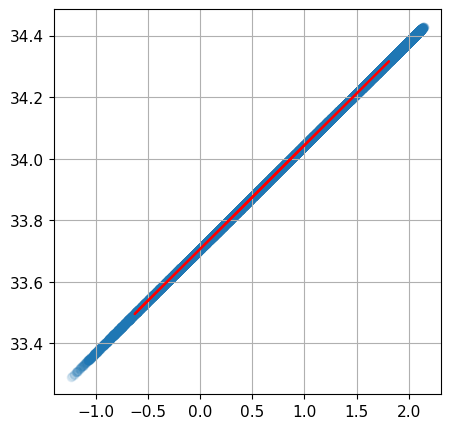

In [37]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(rink_ds.sel(Depth_temp=rink_ds.Depth_CTD.values).temperature.sel(time=slice('2019-03','2019-06')).values.ravel(),linpred,c='r')
plt.scatter(rink_temp_interp_ds.temperature,rink_salinity_pred,alpha=0.1)
plt.grid()

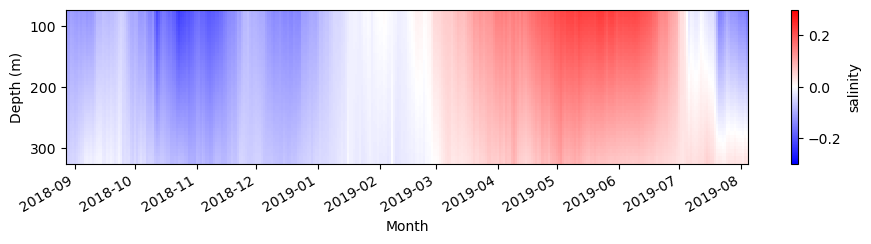

In [148]:
# subtract mean salinity from observed salinity profile and see anomaly over time

plt.figure(figsize=[11,2])
delta = rink_salt_interp_ds.salinity.dropna('depth') - rink_salt_interp_ds.salinity.dropna('depth').mean(dim='time')
delta.plot(cmap='bwr', vmin=-0.3,vmax=0.3)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

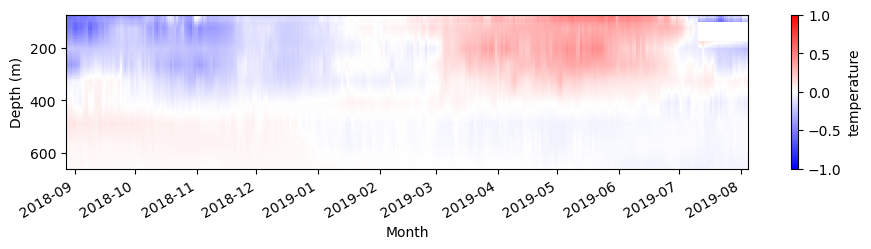

In [165]:
# subtract mean salinity from observed salinity profile and see anomaly over time

plt.figure(figsize=[11,2])
delta = rink_temp_interp_ds.temperature - rink_temp_interp_ds.temperature.mean(dim='time')
delta.plot(cmap='bwr', vmin=-1,vmax=1)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

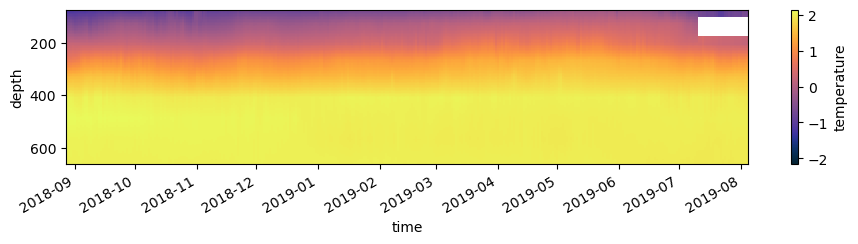

In [169]:
## linear interpolating between two CTDs - temperature
plt.figure(figsize=[11,2])
rink_temp_interp_ds.temperature.plot(cmap=cmocean.cm.thermal)
# plt.ylim(rink_salt_interp_ds.salinity.dropna('depth').depth.min(),rink_salt_interp_ds.salinity.dropna('depth').depth.max())
plt.gca().invert_yaxis()

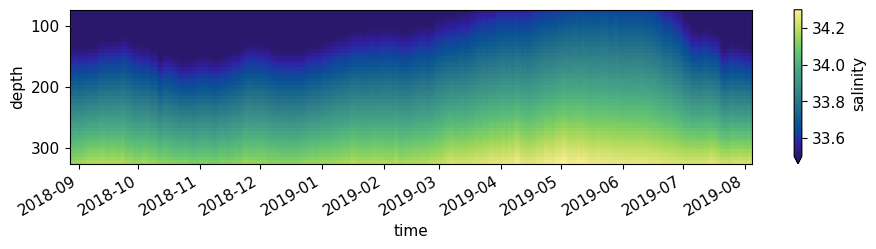

In [224]:
## linear interpolating between two CTDs
plt.figure(figsize=[11,2])
rink_salt_interp_ds.salinity.dropna('depth').plot(cmap=cmocean.cm.haline,vmin=33.5, vmax=34.3)
plt.gca().invert_yaxis()

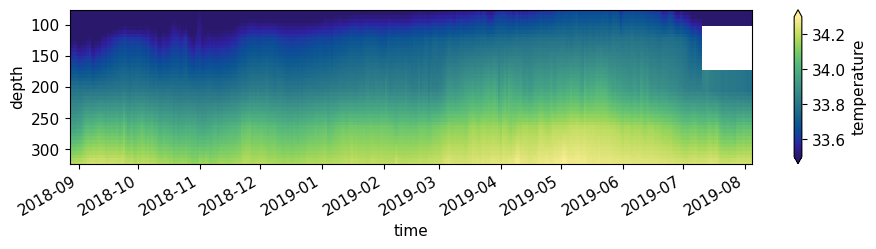

In [232]:
# show predicted/expected salinity from TS linear fit using observed temperatures
plt.figure(figsize=[11,2])
salinity_pred.plot(cmap=cmocean.cm.haline,vmin=33.5, vmax=34.3)
plt.ylim(rink_salt_interp_ds.salinity.dropna('depth').depth.min(),rink_salt_interp_ds.salinity.dropna('depth').depth.max())
plt.gca().invert_yaxis();

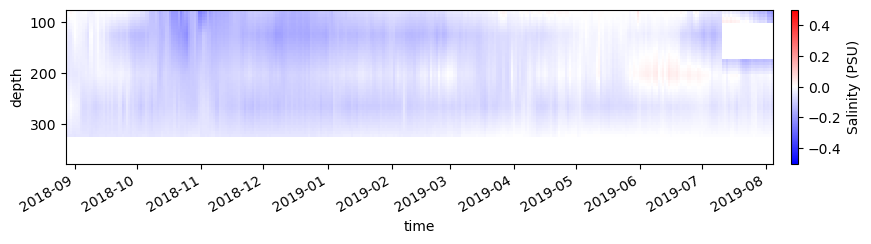

In [210]:
# now subtract predicted salinities from linear interpolation between CTD salinity observations
plt.figure(figsize=[11,2])
delta  = rink_salt_interp_ds.salinity - rink_salinity_pred
delta.plot(cmap='bwr',vmin=-.5, vmax=.5, cbar_kwargs={'pad':0.02,'label':'Salinity (PSU)'})
# plt.ylim(rink_salt_interp_ds.salinity.dropna('depth').depth.min(),rink_salt_interp_ds.salinity.dropna('depth').depth.max())
plt.ylim(rink_salt_interp_ds.salinity.dropna('depth').depth.min(), fisher_salt_interp_ds.depth.max())
plt.gca().invert_yaxis()

# plt.savefig("figures/TS_relationship/Rink_salt_delta.png", bbox_inches='tight', dpi=300)

#### FISHER

In [10]:
# load interpolated temp and salinity datasets
mooring_interp_path = 'C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/'
fisher_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Fisher_1D_interpolated_temp_profile.nc')
fisher_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Fisher_1D_interpolated_salt_profile.nc')

In [38]:
linpred, params, fisher_salinity_pred = pred_salt_from_temp_linear_fit(fisher_ds,fisher_temp_interp_ds)

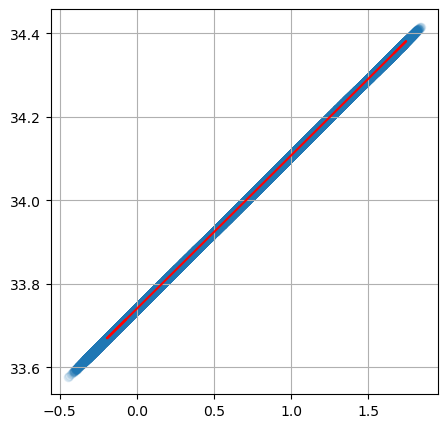

In [108]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(fisher_ds.sel(Depth_temp=fisher_ds.Depth_CTD.values).temperature.sel(time=slice('2020-03','2020-06')).values.ravel(),linpred,c='r')
plt.scatter(fisher_temp_interp_ds.temperature,fisher_salinity_pred,alpha=0.1)
plt.grid()

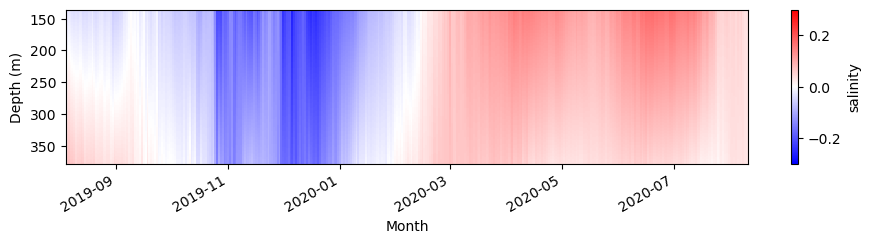

In [149]:
# subtract mean salinity from observed salinity profile and see anomaly over time

plt.figure(figsize=[11,2])
delta = fisher_salt_interp_ds.salinity.dropna('depth') - fisher_salt_interp_ds.salinity.dropna('depth').mean(dim='time')
delta.plot(cmap='bwr', vmin=-0.3,vmax=0.3)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

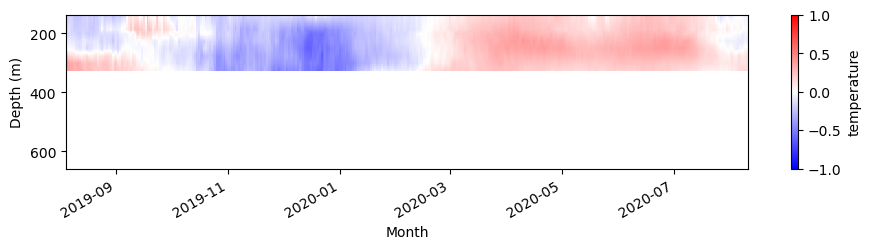

In [167]:
# subtract mean salinity from observed salinity profile and see anomaly over time

plt.figure(figsize=[11,2])
delta = fisher_temp_interp_ds.temperature.dropna('depth') - fisher_temp_interp_ds.temperature.dropna('depth').mean(dim='time')
delta.plot(cmap='bwr', vmin=-1,vmax=1)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.ylim(fisher_temp_interp_ds.depth.min(), rink_temp_interp_ds.depth.max())
plt.gca().invert_yaxis()

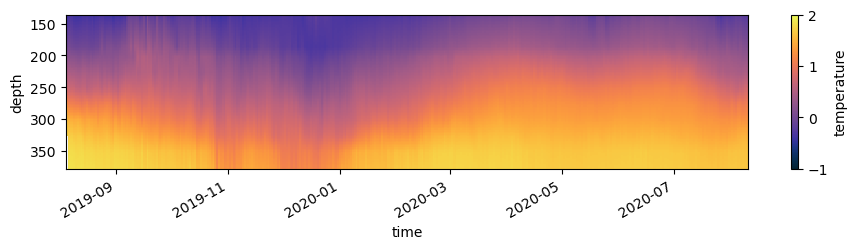

In [110]:
## linear interpolating between two CTDs - temperature
plt.figure(figsize=[11,2])
fisher_temp_interp_ds.temperature.plot(cmap=cmocean.cm.thermal,vmin=-1,vmax=2)
plt.gca().invert_yaxis()

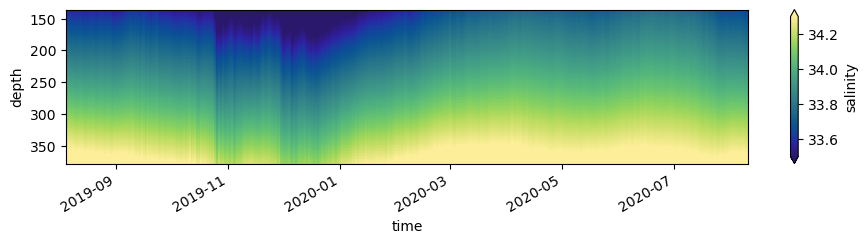

In [111]:
## linear interpolating between two CTDs
plt.figure(figsize=[11,2])
fisher_salt_interp_ds.salinity.dropna('depth').plot(cmap=cmocean.cm.haline,vmin=33.5, vmax=34.3)
plt.gca().invert_yaxis()

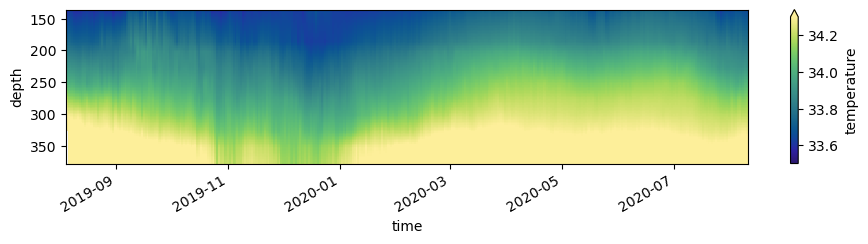

In [112]:
# show predicted/expected salinity from TS linear fit using observed temperatures
plt.figure(figsize=[11,2])
salinity_pred.plot(cmap=cmocean.cm.haline,vmin=33.5, vmax=34.3)
plt.gca().invert_yaxis();

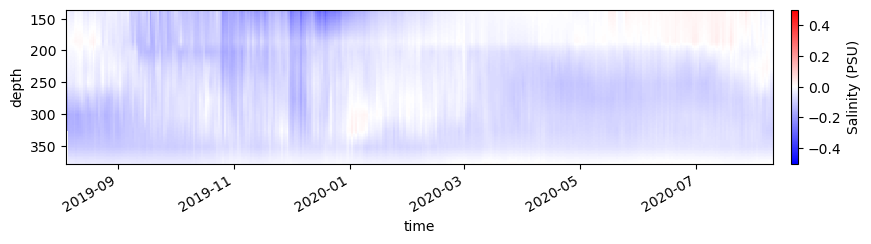

In [136]:
# now subtract predicted salinities from linear interpolation between CTD salinity observations
plt.figure(figsize=[11,2])
delta  = fisher_salt_interp_ds.salinity - fisher_salinity_pred
delta.plot(cmap='bwr',vmin=-.5, vmax=.5, cbar_kwargs={'pad':0.02,'label':'Salinity (PSU)'})
plt.gca().invert_yaxis()

# plt.savefig("figures/TS_relationship/Rink_salt_delta.png", bbox_inches='tight', dpi=300)

#### KONG OSCAR

In [41]:
# load interpolated temp and salinity datasets
mooring_interp_path = 'C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/'
KO_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_temp_profile.nc').sortby("time")
KO_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_salt_profile.nc').sortby("time")

Need to handle Kong Oscar differently because we have two years worth of data and need to extract March-June from each year (separate datasets)

In [ ]:
kongoscar_ds = xr.concat([kongoscar19,kongoscar20],)

In [42]:
mooring_MarJun_19_ds = kongoscar19.sel(time=slice('2019-03','2019-06'))
mooring_MarJun_20_ds = kongoscar20.sel(time=slice('2020-03','2020-06'))
mooring_MarJun_ds = xr.concat([mooring_MarJun_19_ds, mooring_MarJun_20_ds], dim='time')

# assign X and Y for linear fit (we want salinity to be response because we will predict salinity using temp)
yy = mooring_MarJun_ds.salinity.values
xx = mooring_MarJun_ds.sel(Depth_temp=kongoscar_ds.Depth_CTD.values).temperature.values
# drop nans
yy_array = yy[~np.isnan(yy)]
xx_array = xx[~np.isnan(xx)]
# add constant
X = sm.add_constant(xx_array)

In [40]:
# run OLS linear fit
linmodel = sm.OLS(yy_array, X)
results = linmodel.fit()
linpred = results.predict(X)
params = results.params

# predict salinity using temperature values and linear fit
# params is indexed: [intercept, slope]
KO_salinity_pred = params[1]*KO_temp_interp_ds.temperature + params[0]

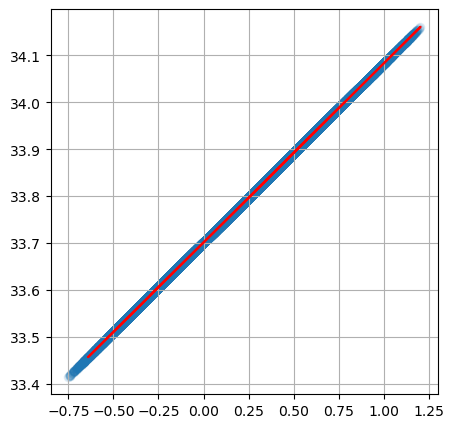

In [91]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(X[:,1],linpred,c='r')
plt.scatter(KO_temp_interp_ds.temperature,KO_salinity_pred,alpha=0.1)
plt.grid()

In [152]:
KO_salt_interp_ds.salinity.mean(dim='time', skipna=True)

<xarray.DataArray 'salinity' (depth: 100)>
array([33.34909859, 33.36226228, 33.36929427, 33.37624243, 33.38359011,
       33.39052501, 33.3974599 , 33.4774611 , 33.48362183, 33.48978256,
       33.49594329, 33.50210402, 33.50826475, 33.51442549, 33.52058622,
       33.52674695, 33.53290768, 33.53942933, 33.54558536, 33.55174138,
       33.55789741, 33.56405344, 33.57020947, 33.57636549, 33.58252152,
       33.58867755, 33.59483358, 33.6009896 , 33.60714563, 33.61330166,
       33.61945769, 33.62561371, 33.63176974, 33.63792577, 33.64408179,
       33.65023782, 33.65639385, 33.66254988, 33.6687059 , 33.67486193,
       33.68101796, 33.68717399, 33.69333001, 33.69948604, 33.70564207,
       33.7117981 , 33.71795412, 33.72411015, 33.73026618, 33.7364222 ,
       33.74257823, 33.74873426, 33.75489029, 33.76104631, 33.76720234,
       33.77335837, 33.7795144 , 33.78567042, 33.79182645, 33.79798248,
       33.80413851, 33.81029453, 33.81645056, 33.82260659, 33.82876262,
       33.83491864, 33.84107467, 33.8472307 , 33.85338672, 33.85954275,
       33.86569878, 33.87185481, 33.87801083, 33.88416686, 33.89032289,
       33.89647892, 33.90263494, 33.90879097, 33.914947  , 33.92110303,
       33.94246103, 33.94763185, 33.95280267, 33.95797349, 33.96844396,
       33.97464067, 33.97970521, 33.98627914, 33.99132402, 33.98659407,
       33.99191868, 33.9972433 , 34.00256792, 34.00789254, 34.01321715,
       34.01854177, 34.02386639, 34.029191  , 34.03451562, 34.03984024])
Coordinates:
  * depth    (depth) float64 94.0 95.65 97.3 98.95 ... 252.5 254.2 255.8 257.5
    SN_CTD   (depth) object 'SBE37_03716754' ... 'SBE37_03716526'

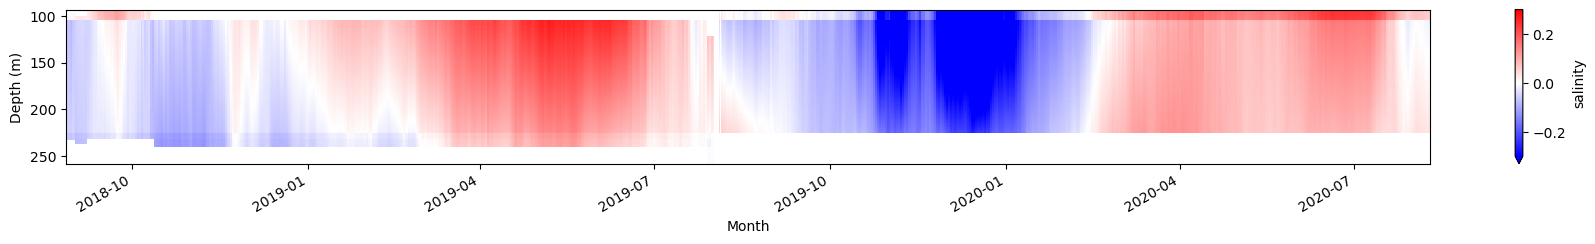

In [154]:
# subtract mean salinity from observed salinity profile and see anomaly over time
plt.figure(figsize=[22,2])
delta = KO_salt_interp_ds.salinity - KO_salt_interp_ds.salinity.mean(dim='time', skipna=True)
delta.plot(cmap='bwr', vmin=-0.3, vmax=0.3)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

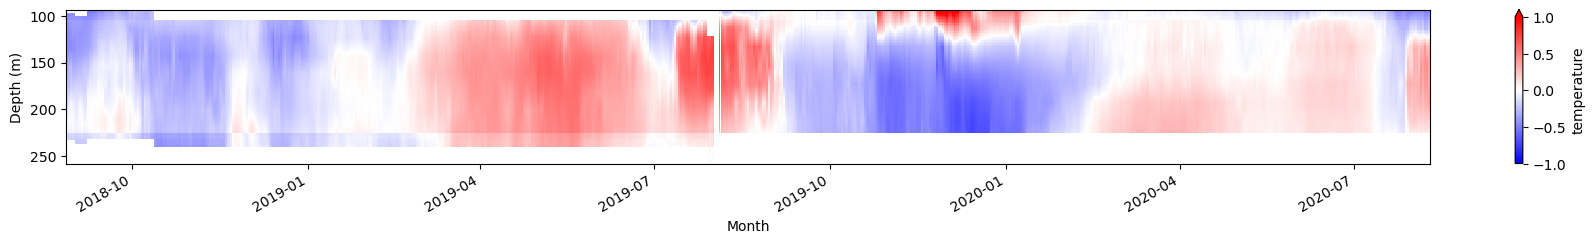

In [159]:
# subtract mean temp from observed temp profile and see anomaly over time
plt.figure(figsize=[22,2])
delta = KO_temp_interp_ds.temperature - KO_temp_interp_ds.temperature.mean(dim='time', skipna=True)
delta.plot(cmap='bwr', vmin=-1,vmax=1)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

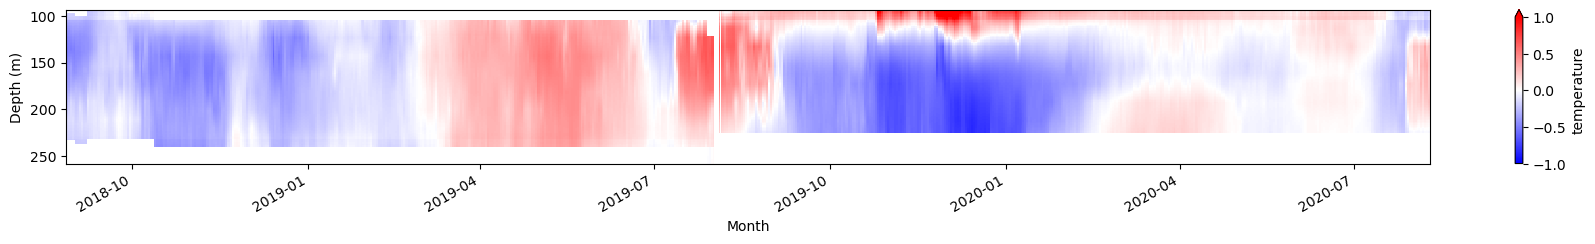

In [175]:
# subtract mean temp from observed temp profile and see anomaly over time
plt.figure(figsize=[22,2])
delta = KO_temp_interp_ds.temperature - KO_temp_interp_ds.sel(time=slice('2018','2019-08-20')).temperature.mean(dim='time', skipna=True)
delta.plot(cmap='bwr', vmin=-1,vmax=1)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

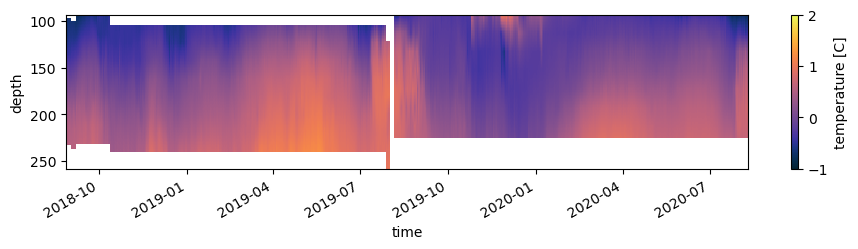

In [94]:
## linear interpolating between two CTDs
plt.figure(figsize=[11,2])
KO_temp_interp_ds.temperature.plot(cmap=cmocean.cm.thermal,vmin=-1,vmax=2)
plt.gca().invert_yaxis()

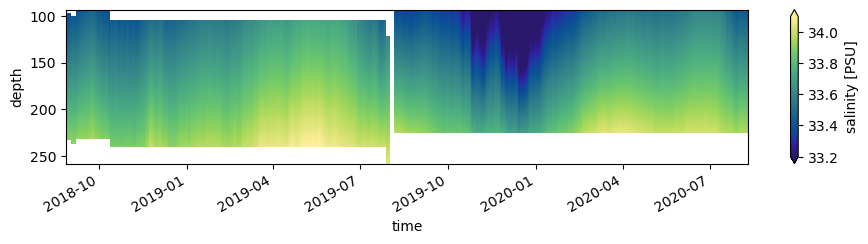

In [95]:
## linear interpolating between two CTDs
plt.figure(figsize=[11,2])
KO_salt_interp_ds.salinity.plot(cmap=cmocean.cm.haline,vmin=33.2, vmax=34.1)
plt.gca().invert_yaxis()

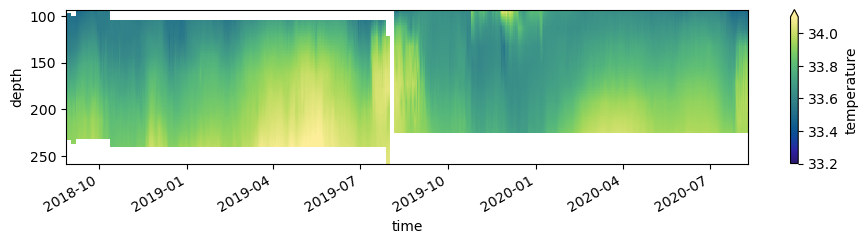

In [100]:
# show predicted/expected salinity from TS linear fit using observed temperatures
plt.figure(figsize=[11,2])
salinity_pred.plot(cmap=cmocean.cm.haline,vmin=33.2, vmax=34.1)
plt.gca().invert_yaxis();

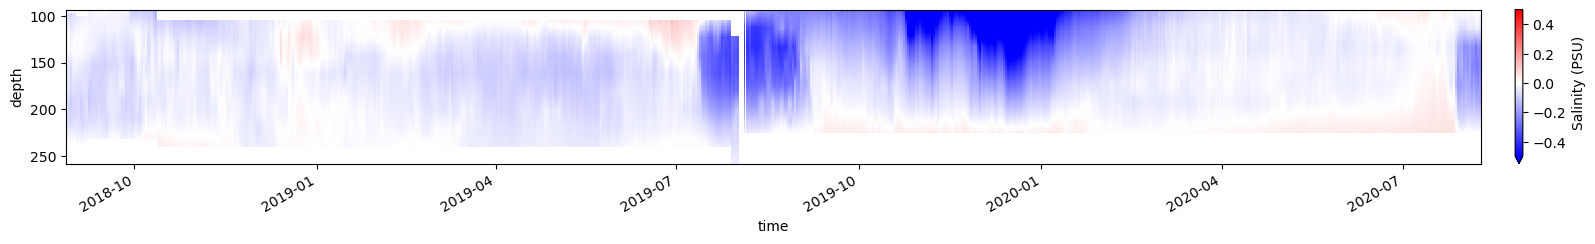

In [216]:
# now subtract predicted salinities from linear interpolation between CTD salinity observations
plt.figure(figsize=[22,2])
delta  = KO_salt_interp_ds.salinity - KO_salinity_pred
delta.plot(cmap='bwr',vmin=-.5, vmax=.5, cbar_kwargs={'pad':0.02,'label':'Salinity (PSU)'})
# plt.ylim(rink_salt_interp_ds.salinity.dropna('depth').depth.min(),rink_salt_interp_ds.salinity.dropna('depth').depth.max())
plt.gca().invert_yaxis()

# plt.savefig("figures/TS_relationship/Rink_salt_delta.png", bbox_inches='tight', dpi=300)

#### SVERDRUP

In [12]:
# load interpolated temp and salinity datasets
mooring_interp_path = 'C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/'
sverdrup_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_temp_profile.nc')
sverdrup_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_salt_profile.nc')

In [ ]:
linpred, params, sver_salinity_pred = pred_salt_from_temp_linear_fit(sverdrup_ds,sverdrup_temp_interp_ds)

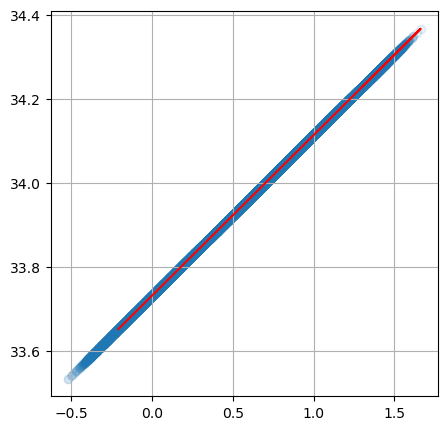

In [181]:
# sanity check plot
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(sverdrup_ds.sel(Depth_temp=sverdrup_ds.Depth_CTD.values).temperature.sel(time=slice('2019-03','2019-06')).values.ravel(),linpred,c='r')
plt.scatter(sverdrup_temp_interp_ds.temperature,sver_salinity_pred,alpha=0.1)
plt.grid()

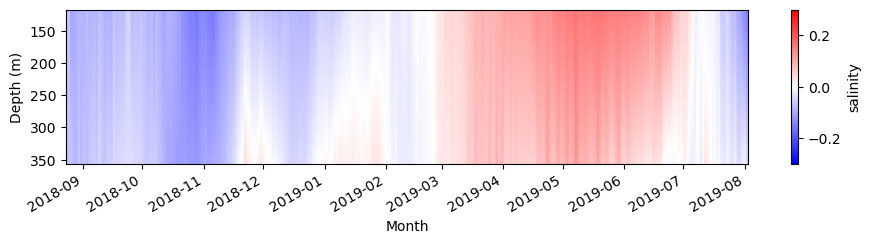

In [155]:
# subtract mean salinity from observed salinity profile and see anomaly over time

plt.figure(figsize=[11,2])
delta = sverdrup_salt_interp_ds.salinity.dropna('depth') - sverdrup_salt_interp_ds.salinity.dropna('depth').mean(dim='time')
delta.plot(cmap='bwr', vmin=-0.3, vmax=0.3)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

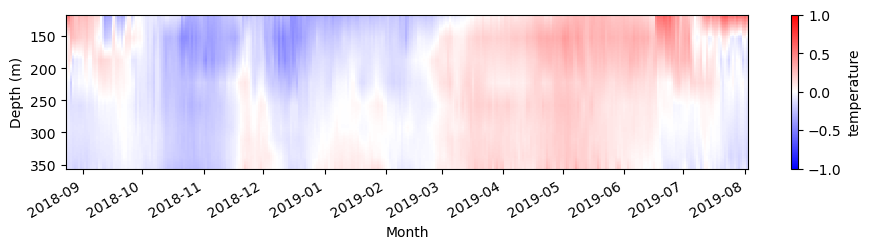

In [160]:
# subtract mean temp from observed temp profile and see anomaly over time
plt.figure(figsize=[11,2])
delta = sverdrup_temp_interp_ds.temperature.dropna('depth') - sverdrup_temp_interp_ds.temperature.dropna('depth').mean(dim='time')
delta.plot(cmap='bwr', vmin=-1,vmax=1)
# delta.plot(cmap='bwr',vmin=-.15, vmax=.15)
plt.xlabel("Month")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()

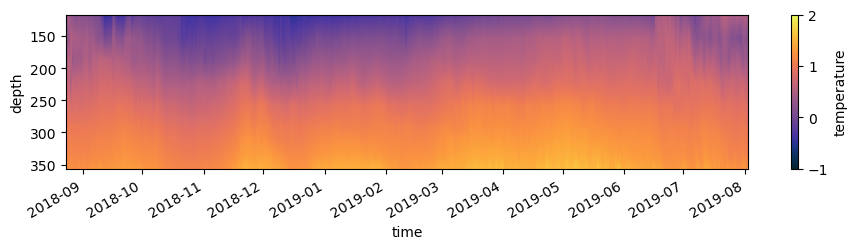

In [118]:
## linear interpolating between two CTDs - temperature
plt.figure(figsize=[11,2])
sverdrup_temp_interp_ds.temperature.plot(cmap=cmocean.cm.thermal,vmin=-1,vmax=2)
plt.gca().invert_yaxis()

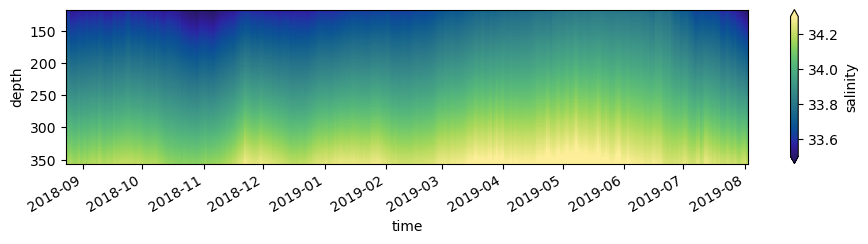

In [119]:
## linear interpolating between two CTDs
plt.figure(figsize=[11,2])
sverdrup_salt_interp_ds.salinity.dropna('depth').plot(cmap=cmocean.cm.haline,vmin=33.5, vmax=34.3)
plt.gca().invert_yaxis()

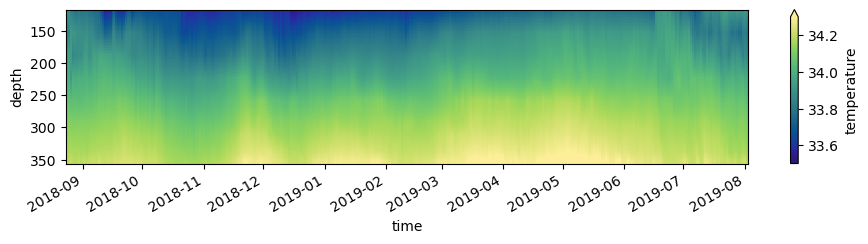

In [182]:
# show predicted/expected salinity from TS linear fit using observed temperatures
plt.figure(figsize=[11,2])
sver_salinity_pred.plot(cmap=cmocean.cm.haline,vmin=33.5, vmax=34.3)
plt.gca().invert_yaxis();

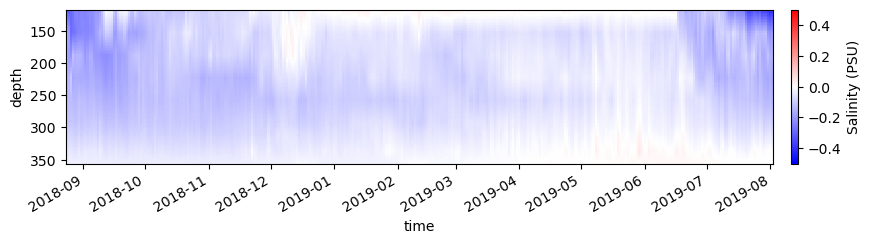

In [183]:
# now subtract predicted salinities from linear interpolation between CTD salinity observations
plt.figure(figsize=[11,2])
delta  = sverdrup_salt_interp_ds.salinity - sver_salinity_pred
delta.plot(cmap='bwr',vmin=-.5, vmax=.5, cbar_kwargs={'pad':0.02,'label':'Salinity (PSU)'})
plt.gca().invert_yaxis()

# plt.savefig("figures/TS_relationship/Rink_salt_delta.png", bbox_inches='tight', dpi=300)

## Make multi-panel plot showing difference in expected salinity (using linear fit) and observed salinity

In [ ]:
from matplotlib import gridspec

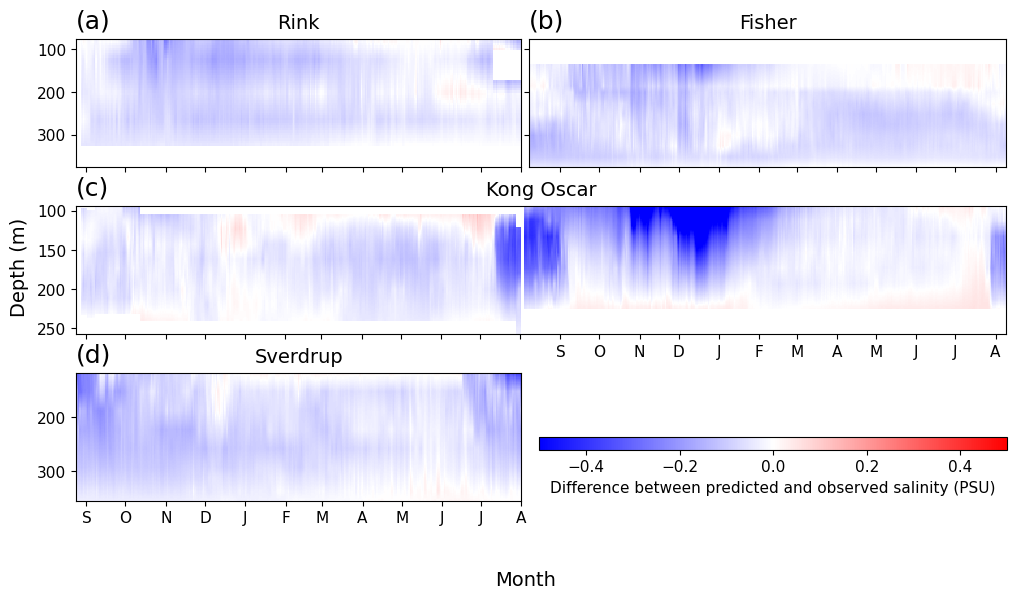

In [416]:
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1, 1.07], wspace=0.017,
                         hspace=0.3)

# fig = plt.figure(figsize=(12, 6))
# axs[0] = fig.add_subplot(3,2,1) # two rows, two columns, first cell
# axs[1] = fig.add_subplot(3,2,2) # two rows, two columns, second cell
# # Create third axes, a combination of third and fourth cell
# axs[2] = fig.add_subplot(3,2,(3,4)) # two rows, two colums, combined third and fourth cell
# axs[4] = fig.add_subplot(3,2,5)

fig = plt.figure(figsize=(12, 6))
axs[0] = fig.add_subplot(spec[0]) # two rows, two columns, first cell
axs[1] = fig.add_subplot(spec[1]) # two rows, two columns, second cell
# Create third axes, a combination of third and fourth cell
axs[2] = fig.add_subplot(3,2,(3,4)) # two rows, two colums, combined third and fourth cell
axs[4] = fig.add_subplot(spec[4])

plt.rcParams['font.size'] = '11'
# fig.subplots_adjust(hspace=0.3, wspace=0.02)

(rink_salt_interp_ds.salinity-rink_salinity_pred).plot(ax=axs[0],cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False)
(fisher_salt_interp_ds.salinity-fisher_salinity_pred).plot(ax=axs[1],cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False)
cbar = (KO_salt_interp_ds.salinity-KO_salinity_pred).plot(ax=axs[2],cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False)
# (KO_salt_interp_ds.salinity-KO_salinity_pred).plot(ax=axs[3],cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False)
(sverdrup_salt_interp_ds.salinity-sver_salinity_pred).plot(ax=axs[4],cmap='bwr',vmin=-.5, vmax=.5,add_colorbar=False)

# set axis limits
axs[0].set_ylim(fisher_salt_interp_ds.depth.max(),rink_salt_interp_ds.depth.min())
axs[1].set_ylim(fisher_salt_interp_ds.depth.max(),rink_salt_interp_ds.depth.min())
axs[2].set_ylim(KO_salt_interp_ds.depth.max(),KO_salt_interp_ds.depth.min())
axs[4].set_ylim(sverdrup_salt_interp_ds.depth.max(),sverdrup_salt_interp_ds.depth.min())

axs[0].set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))
axs[1].set_xlim(fisher_salt_interp_ds.isel(time=3).time,KO_salt_interp_ds.time.isel(time=len(KO_salt_interp_ds.time.values)-1))
axs[2].set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,KO_salt_interp_ds.time.isel(time=len(KO_salt_interp_ds.time.values)-1))
axs[4].set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))

# subplot labels -----------------------------------------------------------------------
axs[0].set_title("(a)",loc='left',y=1.3, pad=-20,fontsize = 18)
axs[1].set_title("(b)",loc='left',y=1.3, pad=-20,fontsize = 18)
axs[2].set_title("(c)",loc='left',y=1.3, pad=-20,fontsize = 18)
axs[4].set_title("(d)",loc='left',y=1.3, pad=-20,fontsize = 18)

axs[0].set_title("Rink",      loc='center',y=1.3, pad=-20,fontsize = 14)
axs[1].set_title("Fisher",    loc='center',y=1.3, pad=-20,fontsize = 14)
axs[2].set_title("Kong Oscar",loc='center',y=1.3, pad=-20,fontsize = 14)
axs[4].set_title("Sverdrup",  loc='center',y=1.3, pad=-20,fontsize = 14)

# remove y-axis tick labels for subplot 2
axs[1].yaxis.set_ticklabels([])

# settings for ticks and tick labels ----------------------------------------------------
# remove the x and y ticks
for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.grid()
    
months18 = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months19 = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A']
abbrev_long = ["","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A']
axs[0].set_xticks(months18, [])
axs[1].set_xticks(months19, [])
axs[2].set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
axs[4].set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

## add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    axs[4],
    width="105%",  # width: 5% of parent_bbox width
    height="10%",
    loc="upper left",
    bbox_to_anchor=(1.04, -0.5, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=axs[4].transAxes,
    borderpad=0)
# (rink_salt_interp_ds.salinity-rink_salinity_pred).plot(ax=axs[0],cmap='bwr',vmin=-.5, vmax=.5)
cb = fig.colorbar(cbar, cax=axins, label='Difference between predicted and observed salinity (PSU)', orientation='horizontal')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.07, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

plt.savefig("../figures/TS_relationship/Salinity_pred-obs_linear-fit.png", bbox_inches='tight', dpi=300)

### Multipanel plot showing variation across depth

In [64]:
mooring_temp_list = [rink_temp_interp_ds, fisher_temp_interp_ds, sverdrup_temp_interp_ds]
mooring_salt_list = [rink_salt_interp_ds, fisher_salt_interp_ds, sverdrup_salt_interp_ds]

In [102]:
# take mean of first mooring
KO19_temp_delta = KO_temp_interp_ds.temperature.sel(time=slice('2018','2019-08-03'))-KO_temp_interp_ds.sel(time=slice('2018','2019-08-03')).temperature.mean(dim='time',skipna=True)
# take mean of second mooring
KO20_temp_delta = KO_temp_interp_ds.temperature.sel(time=slice('2019-08-04','2020'))-KO_temp_interp_ds.sel(time=slice('2019-08-04','2020')).temperature.mean(dim='time',skipna=True)
KO_temp_delta = xr.concat([KO19_temp_delta,KO20_temp_delta], dim='time')

In [105]:
# take mean of first mooring
KO19_salt_delta = KO_salt_interp_ds.salinity.sel(time=slice('2018','2019-08-03'))-KO_salt_interp_ds.sel(time=slice('2018','2019-08-03')).salinity.mean(dim='time',skipna=True)
# take mean of second mooring
KO20_salt_delta = KO_salt_interp_ds.salinity.sel(time=slice('2019-08-04','2020'))-KO_salt_interp_ds.sel(time=slice('2019-08-04','2020')).salinity.mean(dim='time',skipna=True)
KO_salt_delta = xr.concat([KO19_salt_delta,KO20_salt_delta], dim='time')

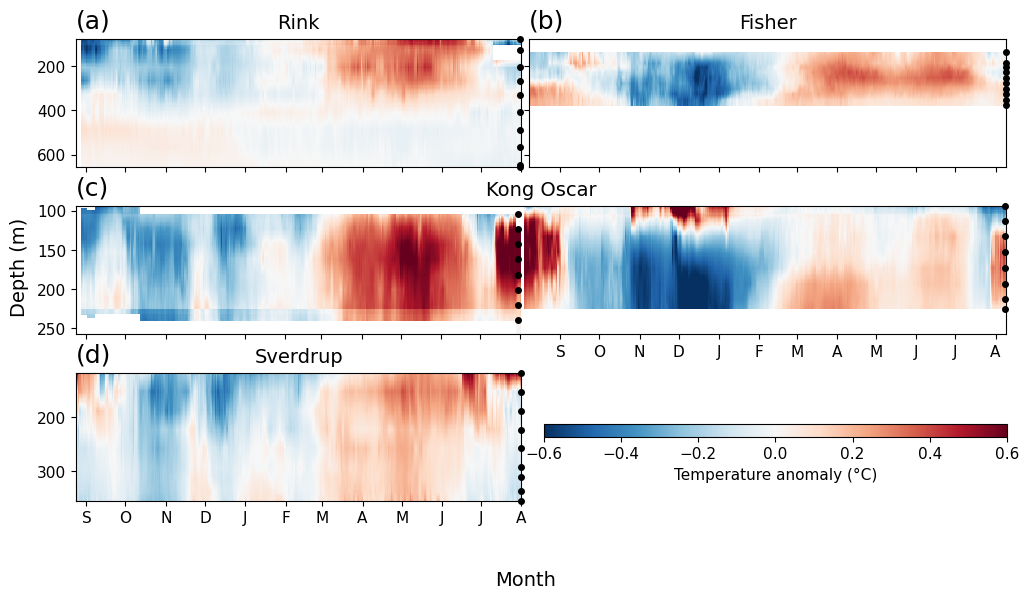

In [122]:
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1, 1.07], wspace=0.017,
                         hspace=0.3)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(spec[0]) # two rows, two columns, first cell
ax2 = fig.add_subplot(spec[1]) # two rows, two columns, second cell
# Create third axes, a combination of third and fourth cell
ax3 = fig.add_subplot(3,2,(3,4)) # two rows, two colums, combined third and fourth cell
ax5 = fig.add_subplot(spec[4])

plt.rcParams['font.size'] = '11'

# plot temperature anomaly
for ax,ds in zip([ax1,ax2,ax5],mooring_temp_list):
    delta = ds.temperature - ds.temperature.mean(dim='time',skipna=True)
    delta.plot(ax=ax, cmap='RdBu_r',vmin=-0.6,vmax=0.6,add_colorbar=False)
# plot kong oscar
# cbar=KO_temp_delta.plot(ax=ax3, cmap='RdBu_r',vmin=-0.6,vmax=0.6,add_colorbar=False) # when each mooring is considered seperately for the mean
cbar=(KO_temp_interp_ds.temperature-KO_temp_interp_ds.temperature.mean(dim='time',skipna=True)).plot(ax=ax3, cmap='RdBu_r',vmin=-0.6,vmax=0.6,add_colorbar=False)

# set axis limits
ax1.set_ylim(rink_temp_interp_ds.depth.max(),rink_temp_interp_ds.depth.min())
ax2.set_ylim(rink_temp_interp_ds.depth.max(),rink_temp_interp_ds.depth.min())
ax3.set_ylim(KO_temp_interp_ds.depth.max(),KO_temp_interp_ds.depth.min())
ax5.set_ylim(sverdrup_temp_interp_ds.depth.max(),sverdrup_temp_interp_ds.depth.min())

ax1.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))
ax2.set_xlim(fisher_temp_interp_ds.isel(time=3).time,KO_temp_interp_ds.time.isel(time=len(KO_temp_interp_ds.time.values)-1))
ax3.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,KO_temp_interp_ds.time.isel(time=len(KO_temp_interp_ds.time.values)-1))
ax5.set_xlim(sverdrup_temp_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))

# subplot labels -----------------------------------------------------------------------
ax1.set_title("(a)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax2.set_title("(b)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax3.set_title("(c)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax5.set_title("(d)",loc='left',y=1.3, pad=-20,fontsize = 18)

ax1.set_title("Rink",      loc='center',y=1.3, pad=-20,fontsize = 14)
ax2.set_title("Fisher",    loc='center',y=1.3, pad=-20,fontsize = 14)
ax3.set_title("Kong Oscar",loc='center',y=1.3, pad=-20,fontsize = 14)
ax5.set_title("Sverdrup",  loc='center',y=1.3, pad=-20,fontsize = 14)

# remove y-axis tick labels for subplot 2
ax2.yaxis.set_ticklabels([])

# settings for ticks and tick labels ----------------------------------------------------
# remove the x and y ticks
for ax in [ax1,ax2,ax3,ax5]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.grid()
    
months18 = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months19 = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A']
abbrev_long = ["","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax1.set_xticks(months18, [])
ax2.set_xticks(months19, [])
ax3.set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
ax5.set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

## add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    ax5,
    width="104%",  # width: 5% of parent_bbox width
    height="10%",
    loc="upper left",
    bbox_to_anchor=(1.05, -0.4, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=ax5.transAxes,
    borderpad=0)

fig.colorbar(cbar, cax=axins, label='Temperature anomaly (°C)', orientation='horizontal')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.07, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

## add sensor depths ------------------------------------------------------------------
ax1.plot(list(itertools.repeat(rink_ds.time[-5].values, len(rink_ds.Depth_temp))), rink_ds.Depth_temp.values,"o", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(fisher_ds.time[-2].values, len(fisher_ds.Depth_temp))), fisher_ds.Depth_temp.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar19.time[-5].values, len(kongoscar19.Depth_temp))), kongoscar19.Depth_temp.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar20.time[-2].values, len(kongoscar20.Depth_temp))), kongoscar20.Depth_temp.values,"o", color='black', markersize=4, clip_on=False)
ax5.plot(list(itertools.repeat(sverdrup_ds.time[-2].values, len(sverdrup_ds.Depth_temp))), sverdrup_ds.Depth_temp.values,"o", color='black', markersize=4, clip_on=False,\
           label='Sensor depth');
# ax5.legend(bbox_to_anchor=(0.75, -0.3, 1, 1));

plt.savefig("../figures/profiles/Mooring_profiles_depth-anomaly-temp.png", bbox_inches='tight', dpi=300)

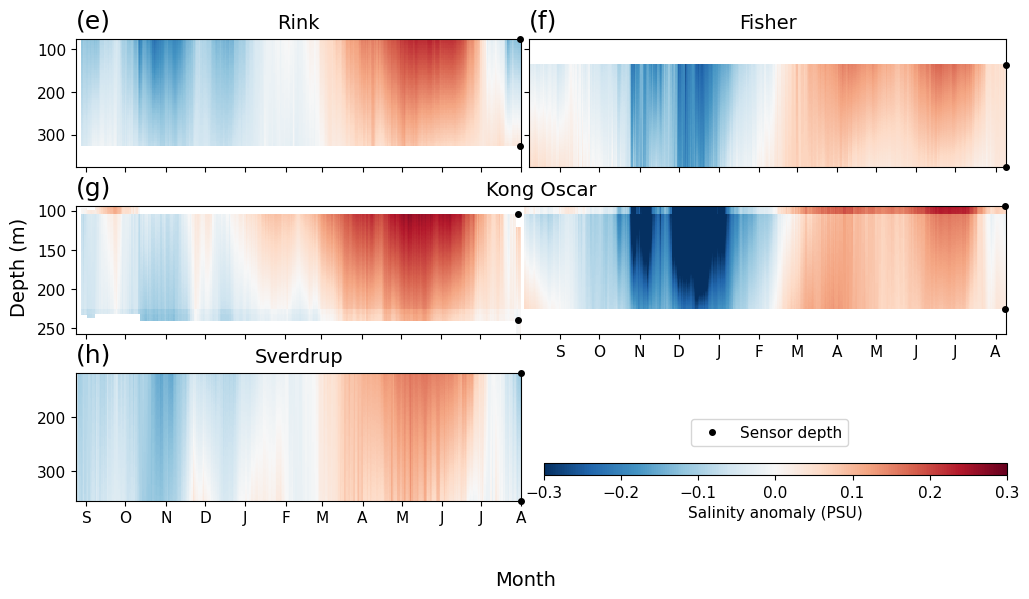

In [121]:
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         width_ratios=[1, 1.07], wspace=0.017,
                         hspace=0.3)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(spec[0]) # two rows, two columns, first cell
ax2 = fig.add_subplot(spec[1]) # two rows, two columns, second cell
# Create third axes, a combination of third and fourth cell
ax3 = fig.add_subplot(3,2,(3,4)) # two rows, two colums, combined third and fourth cell
ax5 = fig.add_subplot(spec[4])

plt.rcParams['font.size'] = '11'

# for all the same temp/salinity scales between all mooring plots:
levels_salt=np.arange(33.3,34.3,0.04)

# plot temperature anomaly
for ax,ds in zip([ax1,ax2,ax5],mooring_salt_list):
    delta = ds.salinity - ds.salinity.mean(dim='time',skipna=True)
    delta.plot(ax=ax, cmap='RdBu_r',vmin=-0.3,vmax=0.3,add_colorbar=False)
# plot kong oscar
# cbar=KO_salt_delta.plot(ax=ax3, cmap='RdBu_r',vmin=-0.3,vmax=0.3,add_colorbar=False) # when each mooring is considered seperately for the mean
cbar=(KO_salt_interp_ds.salinity-KO_salt_interp_ds.salinity.mean(dim='time',skipna=True)).plot(ax=ax3, cmap='RdBu_r',vmin=-0.3,vmax=0.3,add_colorbar=False)

# set axis limits
ax1.set_ylim(fisher_salt_interp_ds.depth.max(),rink_salt_interp_ds.depth.min())
ax2.set_ylim(fisher_salt_interp_ds.depth.max(),rink_salt_interp_ds.depth.min())
ax3.set_ylim(KO_salt_interp_ds.depth.max(),KO_salt_interp_ds.depth.min())
ax5.set_ylim(sverdrup_salt_interp_ds.depth.max(),sverdrup_salt_interp_ds.depth.min())

ax1.set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))
ax2.set_xlim(fisher_salt_interp_ds.isel(time=3).time,KO_salt_interp_ds.time.isel(time=len(KO_salt_interp_ds.time.values)-1))
ax3.set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,KO_salt_interp_ds.time.isel(time=len(KO_salt_interp_ds.time.values)-1))
ax5.set_xlim(sverdrup_salt_interp_ds.isel(time=0).time,np.datetime64('2019-08-01'))

# subplot labels -----------------------------------------------------------------------
ax1.set_title("(e)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax2.set_title("(f)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax3.set_title("(g)",loc='left',y=1.3, pad=-20,fontsize = 18)
ax5.set_title("(h)",loc='left',y=1.3, pad=-20,fontsize = 18)

ax1.set_title("Rink",      loc='center',y=1.3, pad=-20,fontsize = 14)
ax2.set_title("Fisher",    loc='center',y=1.3, pad=-20,fontsize = 14)
ax3.set_title("Kong Oscar",loc='center',y=1.3, pad=-20,fontsize = 14)
ax5.set_title("Sverdrup",  loc='center',y=1.3, pad=-20,fontsize = 14)

# remove y-axis tick labels for subplot 2
ax2.yaxis.set_ticklabels([])

# settings for ticks and tick labels ----------------------------------------------------
# remove the x and y ticks
for ax in [ax1,ax2,ax3,ax5]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.grid()
    
months18 = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months19 = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A']
abbrev_long = ["","","","","","","","","","","","","S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax1.set_xticks(months18, [])
ax2.set_xticks(months19, [])
ax3.set_xticks(months, abbrev_long, rotation=0, horizontalalignment = 'center')
ax5.set_xticks(months18, abbrev, rotation=0, horizontalalignment = 'center')
# axs[3].tick_params(labelbottom=True)

## add colorbar -----------------------------------------------------------------------
axins = inset_axes(
    ax5,
    width="104%",  # width: 5% of parent_bbox width
    height="10%",
    loc="upper left",
    bbox_to_anchor=(1.05, -0.7, 1, 1), # change these values to adjust position of colorbar
    bbox_transform=ax5.transAxes,
    borderpad=0)

fig.colorbar(cbar, cax=axins, label='Salinity anomaly (PSU)', orientation='horizontal')

fig.text(0.5, -0.03, 'Month', size=14, ha='center')
fig.text(0.07, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

## add sensor depths ------------------------------------------------------------------
ax1.plot(list(itertools.repeat(rink_ds.time[-5].values, len(rink_ds.Depth_CTD))), rink_ds.Depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(fisher_ds.time[-2].values, len(fisher_ds.Depth_CTD))), fisher_ds.Depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar19.time[-5].values, len(kongoscar19.Depth_CTD))), kongoscar19.Depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax3.plot(list(itertools.repeat(kongoscar20.time[-2].values, len(kongoscar20.Depth_CTD))), kongoscar20.Depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax5.plot(list(itertools.repeat(sverdrup_ds.time[-2].values, len(sverdrup_ds.Depth_CTD))), sverdrup_ds.Depth_CTD.values,"o", color='black', markersize=4, clip_on=False,\
           label='Sensor depth');
ax5.legend(bbox_to_anchor=(0.75, -0.3, 1, 1));

plt.savefig("../figures/profiles/Mooring_profiles_depth-anomaly-salt.png", bbox_inches='tight', dpi=300)